# Flash Prediction Model

Import Libraries

In [ ]:
import pandas as pd
import numpy as np 
import seaborn as sns

import matplotlib.pyplot as plot
from matplotlib import rcParams
from matplotlib.cm import rainbow
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score,confusion_matrix, f1_score,accuracy_score
from sklearn import * 
from sklearn import model_selection, neighbors

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

print("successful import ;)")

successful import ;)


Read Dataset and preprocess data

In [ ]:
# Loading Data 
data = pd.read_csv("./dataset/POWER_Nairobi_Regional_2000_2022.csv")

In [7]:
# data.info()

In [8]:
# data.describe()

Check the total missing data percentage

In [10]:
missing_data = data.isnull().sum()
total_percentage = (missing_data.sum()/data.shape[0]) * 100
print(f'Total percentage of missing data is {round(total_percentage,2)}%')

Total percentage of missing data is 0.0%


In [11]:
data.duplicated().sum()

0

Normalize continuous variables

In [13]:
scaler = MinMaxScaler()
data[['Wind_Speed_kmh','Temperature','Soil_Moisture_%','Humidity_%','Rainfall_mm',
      'River_Discharge_m3s','Elevation_m']]=scaler.fit_transform(data[['Wind_Speed_kmh', 'Temperature', 'Soil_Moisture_%', 
                                                                       'Humidity_%','Rainfall_mm','River_Discharge_m3s','Elevation_m']])

In [14]:
#data.describe()

Convert categorical variables into numeric using LabelEncoder()

In [16]:
label_encoder = LabelEncoder()

label_encoder.fit(data["Slope_Position"])
slope_data_encoded =  label_encoder.transform(data['Slope_Position'])
data['Slope_Position'] = slope_data_encoded

# Converting Surface Stoniness into numeric values
label_encoder.fit(data['Surface_stoniness'])
stoniness_data_encoded = label_encoder.transform(data['Surface_stoniness'])
data['Surface_stoniness'] = stoniness_data_encoded

# Converting Erosion Degree into numeric values
label_encoder.fit(data['Erosion_degree'])
erosion_degree_data_encoded = label_encoder.transform(data['Erosion_degree'])
data['Erosion_degree'] = erosion_degree_data_encoded

# Converting 'Sensitivity to capping' into numeric values
label_encoder.fit(data['Sensitivity_to_capping'])
sensitivity_to_capping_data_encoded = label_encoder.transform(data['Sensitivity_to_capping'])
data['Sensitivity_to_capping'] = sensitivity_to_capping_data_encoded

# Converting 'Land Use Type' into numeric values
label_encoder.fit(data['Land_Use_Type'])
land_use_type_data_encoded = label_encoder.transform(data['Land_Use_Type'])
data['Land_Use_Type'] = land_use_type_data_encoded  

In [17]:
print(land_use_type_data_encoded)

[1 0 2 0 1 3 0 2 3 0 0 3 3 3 2 2 0 0 1 2 0 3 3 2 3 1 0 0 0 2 3 1 2 0 1 0 0
 2 0 1 0 3 0 2 1 2 3 0 2 2 2 2 3 3 0 0 1 3 2 2 1 2 1 0 3 1 2 1 0 2 0 0 1 0
 2 0 0 1 0 3 1 1 2 2 2 2 3 1 0 2 2 2 0 2 0 1 1 1 3 0 2 2 2 2 3 2 3 0 1 2 1
 0 0 2 0 1 2 3 2 1 2 2 1 2 2 1 0 1 2 3 3 1 3 2 2 1 2 0 2 1 0 0 3 2 1 3 3 2
 2 1 3 1 3 3 3 2 3 3 3 0 2 0 2 1 0 1 3 1 1 1 1 2 0 2 2 2 1 2 0 2 3 1 3 0 0
 0 0 2 1 0 3 0 1 3 3 3 2 0 2 3]


In [18]:
# Check distribution of target class column
data['Flood_Occurrence'].value_counts()

Flood_Occurrence
0    128
1     72
Name: count, dtype: int64

In [19]:
# Check the percentage distribution of the target_class column
data['Flood_Occurrence'].value_counts()/np.int64(len(data))

Flood_Occurrence
0    0.64
1    0.36
Name: count, dtype: float64

In [20]:
correlation_matrix = data.corr()

In [21]:
print(correlation_matrix['Flood_Occurrence'].sort_values(ascending=False))

Flood_Occurrence          1.000000
Rainfall_mm               0.608526
Soil_Moisture_%           0.519057
River_Discharge_m3s       0.484573
Erosion_degree            0.371743
Land_Use_Type             0.163922
Humidity_%                0.088232
Temperature               0.085316
Elevation_m               0.084449
Surface_stoniness         0.066542
Area_affected             0.058898
Wind_Speed_kmh            0.044432
Sensitivity_to_capping   -0.046219
Slope_Position           -0.156961
Name: Flood_Occurrence, dtype: float64


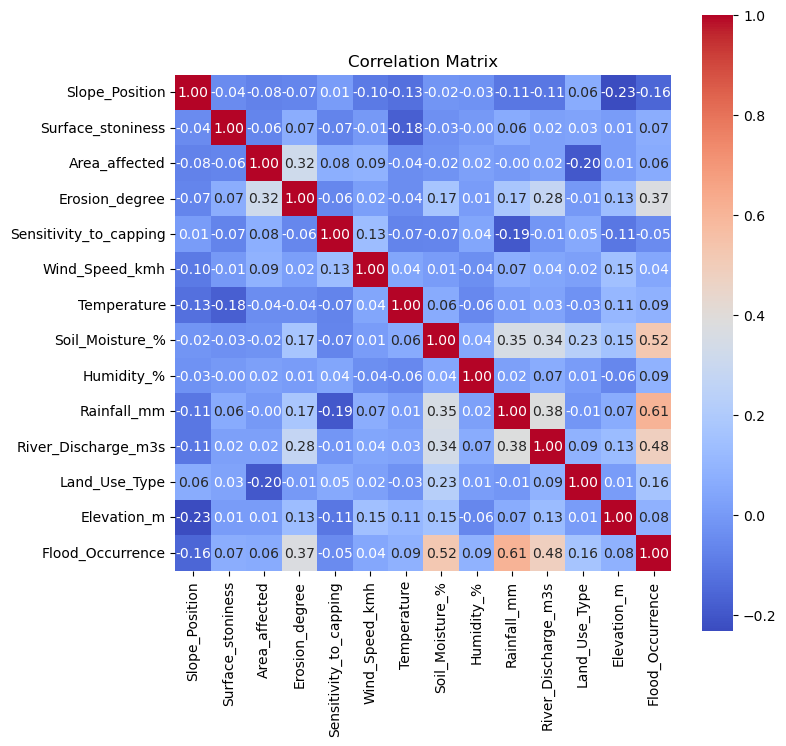

In [22]:
plot.figure(figsize=(8,8))
sns.heatmap(correlation_matrix, vmax=1, annot=True, square=True, fmt=".2f", cmap="coolwarm", cbar=True)
plot.title("Correlation Matrix", fontsize=12)
plot.show()

In [23]:
# Select highly correlated features
correlated_features = correlation_matrix.index[abs(correlation_matrix['Flood_Occurrence']) > 0.3]
print("Factors influencing occurrence of flash floods",correlated_features)

Factors influencing occurrence of flash floods Index(['Erosion_degree', 'Soil_Moisture_%', 'Rainfall_mm',
       'River_Discharge_m3s', 'Flood_Occurrence'],
      dtype='object')


In [24]:
# Removes the Flood_Occurance from independent variables x-axis 
# since it is not a factor in determining
# it is not a a predictor
# X = data.drop(columns=['Flood_Occurrence'])
# Excludes the target column
selected_features = correlated_features.drop('Flood_Occurrence') 
x = data[selected_features]
y = data['Flood_Occurrence']

## Split data into training and testing sets

In [26]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42) #-----> Get back on this 
print("XTrains->",X_train.shape[0],"XTest->",X_test.shape[0],"YTrain->",y_test.shape[0],"YTest->",y_test.shape[0])

XTrains-> 140 XTest-> 60 YTrain-> 60 YTest-> 60


## Traing Models

# 1. Random Forest

In [29]:
rmf_model = RandomForestClassifier(max_depth=3,random_state=0)
rmf_classifier = rmf_model.fit(X_train,y_train)
rmf_classifier

RandomForestClassifier(max_depth=3, random_state=0)

In [30]:
# Make predictions on a set of test data
y_pred = rmf_classifier.predict(X_test)

In [31]:
# Show the accuracy, recall score, and F1 Score
accuracy = accuracy_score(y_test,y_pred) * 100
recall = recall_score(y_test,y_pred) * 100
f1 = f1_score(y_test,y_pred) 
print(f"Accuracy score : {accuracy:.2f} %")
print(f"Recall score : {recall:.2f} %")
print(f"F1 score : {f1:.2f}")

Accuracy score : 93.33 %
Recall score : 90.48 %
F1 score : 0.90


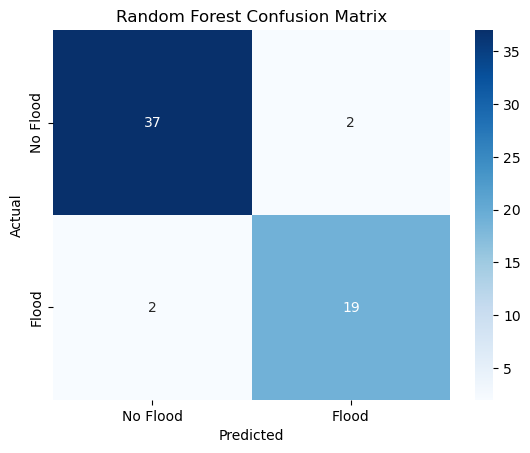

In [32]:
# Confusion Matrix 

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True, fmt='d', cmap='Blues', xticklabels=['No Flood','Flood'], yticklabels=['No Flood','Flood'])
plot.xlabel('Predicted')
plot.ylabel('Actual')
plot.title('Random Forest Confusion Matrix')
plot.show()

# 2. K Nearest Neighbours

In [34]:
# from sklearn import model_selection,neighbors
classifier = neighbors.KNeighborsClassifier()
knn_classifier = classifier.fit(X_train,y_train)

#Predict chances of flood
y_pred = knn_classifier.predict(X_test)

In [35]:
# Compute and print accuracy, recall, F1 score
knn_accuracy = accuracy_score(y_test,y_pred) * 100
knn_recall = recall_score(y_test,y_pred) * 100
knn_F1 = f1_score(y_test,y_pred)
knn_auc = roc_auc_score(y_test,y_pred)

print(f"Accuracy score : {knn_accuracy:.2f} %")
print(f"Recall score : {knn_recall:.2f} %")
print(f"F1 score : {knn_F1:.2f}")
print(f"ROC score : {knn_auc:.2f}")

Accuracy score : 86.67 %
Recall score : 76.19 %
F1 score : 0.80
ROC score : 0.84


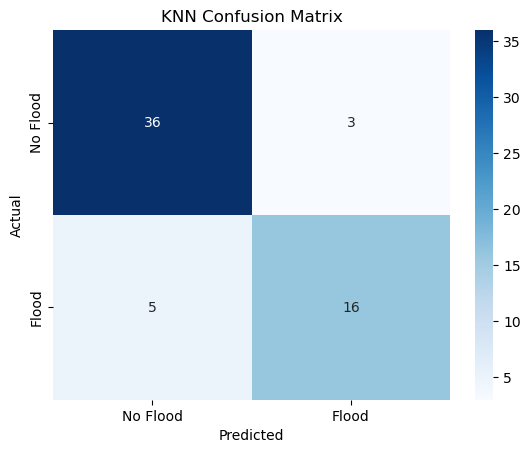

In [36]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Flood", "Flood"], yticklabels=["No Flood", "Flood"])
plot.xlabel('Predicted')
plot.ylabel('Actual')
plot.title('KNN Confusion Matrix')
plot.show()

# 3. Logistic Regression Model

In [38]:
logistic_regression_model = LogisticRegression()
logistic_regression_classifier = logistic_regression_model.fit(X_train,y_train)
logistic_regression_accuracy = cross_val_score(logistic_regression_classifier,X_test,y_test,cv=3,scoring='accuracy',n_jobs=-1)

In [39]:
y_pred = logistic_regression_classifier.predict(X_test)

In [40]:
lr_accuracy = accuracy_score(y_test,y_pred)*100
lr_recall = recall_score(y_test,y_pred)*100
lr_auc = roc_auc_score(y_test,y_pred)*100
lr_f1 = f1_score(y_test, y_pred)
print(f"accuracy score: {lr_accuracy:.2f} %")
print(f"recall score: {lr_recall:.2f} %")
print(f"F1 score: {lr_f1:.2f}")

accuracy score: 90.00 %
recall score: 71.43 %
F1 score: 0.83


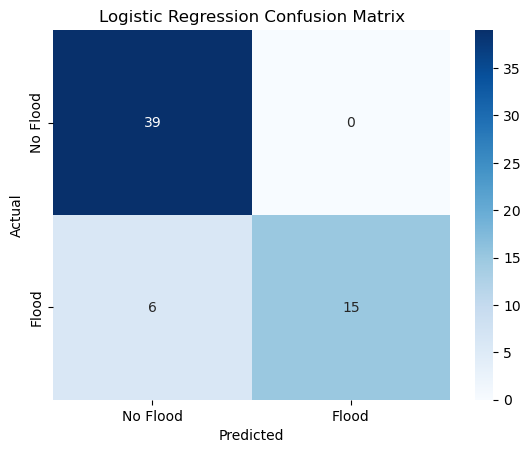

In [41]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Flood", "Flood"], yticklabels=["No Flood", "Flood"])
plot.xlabel('Predicted')
plot.ylabel('Actual')
plot.title('Logistic Regression Confusion Matrix')
plot.show()

# 4. Support Vector Machine

In [43]:
support_vector_model = SVC(kernel = 'linear', C = 1.0)
support_vector_model.fit(X_train, y_train)
svc_prediction_result = support_vector_model.predict(X_test.values)
# print(f"Support Vector Prediction results {svc_prediction_result}")
svc_accuracy = accuracy_score(y_test, y_pred) * 100
svc_recall = recall_score(y_test,y_pred) * 100
svc_f1 = f1_score(y_test, y_pred) * 100
print(f"Accuracy {svc_accuracy:.2f}")
print(f"Recall {svc_recall:.2f}")
print(f"F1 Score {svc_f1:.2f}")

Accuracy 90.00
Recall 71.43
F1 Score 83.33


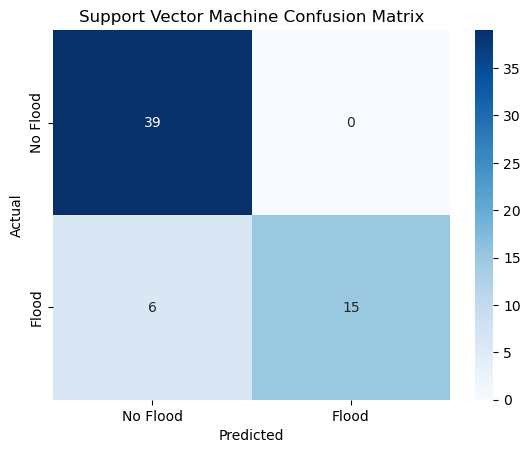

In [44]:
svc_confusion_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(svc_confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Flood", "Flood"], yticklabels=["No Flood", "Flood"])
plot.xlabel('Predicted')
plot.ylabel('Actual')
plot.title('Support Vector Machine Confusion Matrix')
plot.show()

#### Support Vector Plot

# 5. Artificial Neural Network Model

In [47]:
# Number of features from data
number_of_features = X_train.shape[1]
ann_model = Sequential()
ann_model.add(Dense(units = 64, activation = 'relu', input_dim=number_of_features))
ann_model.add(Dense(units = 32, activation = 'relu'))
ann_model.add(Dense(units=1, activation = 'sigmoid'))

# Compile Model
ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('ann_model.h5',save_best_only = True)

# Train the model 
history = ann_model.fit(X_train, y_train, validation_data = (X_test,y_test), 
                        epochs=100, batch_size=32, callbacks=[early_stopping,model_checkpoint])

#Evaluate the model
# loss = ann_model.evaluate(X_test.values, y_test.values)
# print(f"Test Loss: {loss}")
# y_predict = ann_model.predict(X_test.values)

Epoch 1/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 259ms/step - accuracy: 0.3438 - loss: 0.7112

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3913 - loss: 0.7042 - val_accuracy: 0.6500 - val_loss: 0.6776
Epoch 2/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6875 - loss: 0.6774

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6559 - loss: 0.6801 - val_accuracy: 0.6500 - val_loss: 0.6600
Epoch 3/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6875 - loss: 0.6544

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6442 - loss: 0.6669 - val_accuracy: 0.6500 - val_loss: 0.6494
Epoch 4/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6875 - loss: 0.6457

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6373 - loss: 0.6621 - val_accuracy: 0.6500 - val_loss: 0.6401
Epoch 5/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6875 - loss: 0.6337

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6459 - loss: 0.6487 - val_accuracy: 0.6500 - val_loss: 0.6312
Epoch 6/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7188 - loss: 0.6270

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6633 - loss: 0.6397 - val_accuracy: 0.6500 - val_loss: 0.6225
Epoch 7/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6562 - loss: 0.6513

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6590 - loss: 0.6374 - val_accuracy: 0.6667 - val_loss: 0.6137
Epoch 8/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6250 - loss: 0.6303

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6665 - loss: 0.6312 - val_accuracy: 0.7667 - val_loss: 0.6047
Epoch 9/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7188 - loss: 0.6059

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6949 - loss: 0.6189 - val_accuracy: 0.7333 - val_loss: 0.5940
Epoch 10/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7500 - loss: 0.6036

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6923 - loss: 0.6148 - val_accuracy: 0.7500 - val_loss: 0.5848
Epoch 11/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6562 - loss: 0.6206

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7056 - loss: 0.6072 - val_accuracy: 0.7833 - val_loss: 0.5750
Epoch 12/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7188 - loss: 0.6119

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7131 - loss: 0.6027 - val_accuracy: 0.8500 - val_loss: 0.5659
Epoch 13/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7812 - loss: 0.5367

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7721 - loss: 0.5704 - val_accuracy: 0.8500 - val_loss: 0.5537
Epoch 14/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7812 - loss: 0.5635

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7517 - loss: 0.5754 - val_accuracy: 0.8333 - val_loss: 0.5436
Epoch 15/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6875 - loss: 0.5886

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7012 - loss: 0.5787 - val_accuracy: 0.8000 - val_loss: 0.5342
Epoch 16/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6562 - loss: 0.5823

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7088 - loss: 0.5667 - val_accuracy: 0.8333 - val_loss: 0.5244
Epoch 17/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7188 - loss: 0.5765

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7274 - loss: 0.5642 - val_accuracy: 0.8500 - val_loss: 0.5133
Epoch 18/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7188 - loss: 0.6047

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7556 - loss: 0.5582 - val_accuracy: 0.9000 - val_loss: 0.5027
Epoch 19/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7812 - loss: 0.5131

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7489 - loss: 0.5365 - val_accuracy: 0.9167 - val_loss: 0.4920
Epoch 20/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6562 - loss: 0.5623

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7443 - loss: 0.5331 - val_accuracy: 0.9333 - val_loss: 0.4812
Epoch 21/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8750 - loss: 0.5289

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8174 - loss: 0.5183 - val_accuracy: 0.9333 - val_loss: 0.4715
Epoch 22/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7812 - loss: 0.5442

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7868 - loss: 0.5168 - val_accuracy: 0.9500 - val_loss: 0.4622
Epoch 23/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7812 - loss: 0.5182

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8257 - loss: 0.4964 - val_accuracy: 0.9333 - val_loss: 0.4522
Epoch 24/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8125 - loss: 0.5453

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8387 - loss: 0.5047 - val_accuracy: 0.9333 - val_loss: 0.4419
Epoch 25/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8438 - loss: 0.4861

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8467 - loss: 0.4826 - val_accuracy: 0.9500 - val_loss: 0.4293
Epoch 26/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8750 - loss: 0.4687

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8231 - loss: 0.4666 - val_accuracy: 0.9500 - val_loss: 0.4184
Epoch 27/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7500 - loss: 0.5125

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7981 - loss: 0.4794 - val_accuracy: 0.9333 - val_loss: 0.4088
Epoch 28/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8750 - loss: 0.4066

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8333 - loss: 0.4511 - val_accuracy: 0.9500 - val_loss: 0.3999
Epoch 29/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9062 - loss: 0.3829

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8589 - loss: 0.4201 - val_accuracy: 0.9333 - val_loss: 0.3881
Epoch 30/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7812 - loss: 0.4972

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8328 - loss: 0.4408 - val_accuracy: 0.9333 - val_loss: 0.3792
Epoch 31/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8750 - loss: 0.3931

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8688 - loss: 0.4159 - val_accuracy: 0.9500 - val_loss: 0.3709
Epoch 32/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9062 - loss: 0.3401

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8697 - loss: 0.4022 - val_accuracy: 0.9500 - val_loss: 0.3628
Epoch 33/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7500 - loss: 0.4488

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8217 - loss: 0.4210 - val_accuracy: 0.9500 - val_loss: 0.3567
Epoch 34/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9062 - loss: 0.3952

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8632 - loss: 0.4048 - val_accuracy: 0.9500 - val_loss: 0.3479
Epoch 35/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9688 - loss: 0.3370

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8901 - loss: 0.3862 - val_accuracy: 0.9500 - val_loss: 0.3394
Epoch 36/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9062 - loss: 0.3532

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8781 - loss: 0.3844 - val_accuracy: 0.9333 - val_loss: 0.3339
Epoch 37/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8438 - loss: 0.3672

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8426 - loss: 0.3789 - val_accuracy: 0.9500 - val_loss: 0.3229
Epoch 38/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8750 - loss: 0.3656

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8604 - loss: 0.3703 - val_accuracy: 0.9500 - val_loss: 0.3183
Epoch 39/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8125 - loss: 0.4130

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8480 - loss: 0.3809 - val_accuracy: 0.9500 - val_loss: 0.3088
Epoch 40/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9062 - loss: 0.3586

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8745 - loss: 0.3565 - val_accuracy: 0.9500 - val_loss: 0.3018
Epoch 41/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8750 - loss: 0.3310

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8758 - loss: 0.3409 - val_accuracy: 0.9500 - val_loss: 0.2961
Epoch 42/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9688 - loss: 0.2894

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8990 - loss: 0.3334 - val_accuracy: 0.9500 - val_loss: 0.2915
Epoch 43/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8750 - loss: 0.3556

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8740 - loss: 0.3450 - val_accuracy: 0.9333 - val_loss: 0.2836
Epoch 44/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9375 - loss: 0.3133

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8816 - loss: 0.3352 - val_accuracy: 0.9500 - val_loss: 0.2751
Epoch 45/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8125 - loss: 0.3576

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8489 - loss: 0.3317 - val_accuracy: 0.9500 - val_loss: 0.2694
Epoch 46/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8438 - loss: 0.3424

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8641 - loss: 0.3215 - val_accuracy: 0.9500 - val_loss: 0.2644
Epoch 47/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8992 - loss: 0.3034 - val_accuracy: 0.9333 - val_loss: 0.2669
Epoch 48/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9062 - loss: 0.2784

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8786 - loss: 0.3105 - val_accuracy: 0.9500 - val_loss: 0.2580
Epoch 49/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8438 - loss: 0.3367

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8705 - loss: 0.3132 - val_accuracy: 0.9500 - val_loss: 0.2538
Epoch 50/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8438 - loss: 0.3189

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8632 - loss: 0.3119 - val_accuracy: 0.9500 - val_loss: 0.2506
Epoch 51/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9375 - loss: 0.2658

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8970 - loss: 0.2925 - val_accuracy: 0.9500 - val_loss: 0.2448
Epoch 52/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8125 - loss: 0.3437

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8710 - loss: 0.3042 - val_accuracy: 0.9500 - val_loss: 0.2406
Epoch 53/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9688 - loss: 0.2215

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8792 - loss: 0.2948 - val_accuracy: 0.9500 - val_loss: 0.2362
Epoch 54/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8750 - loss: 0.2763

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8664 - loss: 0.3026 - val_accuracy: 0.9500 - val_loss: 0.2281
Epoch 55/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8580 - loss: 0.2958 - val_accuracy: 0.9333 - val_loss: 0.2372
Epoch 56/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8807 - loss: 0.3046 - val_accuracy: 0.9333 - val_loss: 0.2363
Epoch 57/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8125 - loss: 0.3645

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8675 - loss: 0.3099 - val_accuracy: 0.9500 - val_loss: 0.2225
Epoch 58/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9375 - loss: 0.2240

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8849 - loss: 0.2780 - val_accuracy: 0.9500 - val_loss: 0.2182
Epoch 59/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8750 - loss: 0.2766

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8753 - loss: 0.2787 - val_accuracy: 0.9500 - val_loss: 0.2146
Epoch 60/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8996 - loss: 0.2570 - val_accuracy: 0.9500 - val_loss: 0.2149
Epoch 61/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9062 - loss: 0.3014

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8896 - loss: 0.2825 - val_accuracy: 0.9500 - val_loss: 0.2129
Epoch 62/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9375 - loss: 0.2393

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8979 - loss: 0.2625 - val_accuracy: 0.9500 - val_loss: 0.2078
Epoch 63/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8750 - loss: 0.2175

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8653 - loss: 0.2690 - val_accuracy: 0.9500 - val_loss: 0.2024
Epoch 64/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9062 - loss: 0.2353

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8790 - loss: 0.2731 - val_accuracy: 0.9500 - val_loss: 0.1984
Epoch 65/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8797 - loss: 0.2769 - val_accuracy: 0.9500 - val_loss: 0.2023
Epoch 66/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8792 - loss: 0.2536 - val_accuracy: 0.9333 - val_loss: 0.2038
Epoch 67/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8580 - loss: 0.2753 - val_accuracy: 0.9500 - val_loss: 0.2008
Epoch 68/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8125 - loss: 0.3134

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8593 - loss: 0.2795 - val_accuracy: 0.9500 - val_loss: 0.1924
Epoch 69/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8438 - loss: 0.2984

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8697 - loss: 0.2754 - val_accuracy: 0.9333 - val_loss: 0.1917
Epoch 70/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9062 - loss: 0.2524

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8883 - loss: 0.2593 - val_accuracy: 0.9500 - val_loss: 0.1913
Epoch 71/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8905 - loss: 0.2553 - val_accuracy: 0.9500 - val_loss: 0.1915
Epoch 72/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9375 - loss: 0.2674

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8953 - loss: 0.2549 - val_accuracy: 0.9500 - val_loss: 0.1890
Epoch 73/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8750 - loss: 0.2197

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8771 - loss: 0.2459 - val_accuracy: 0.9500 - val_loss: 0.1819
Epoch 74/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8619 - loss: 0.2826 - val_accuracy: 0.9500 - val_loss: 0.1857
Epoch 75/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9062 - loss: 0.2639

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8992 - loss: 0.2466 - val_accuracy: 0.9500 - val_loss: 0.1812
Epoch 76/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8899 - loss: 0.2367 - val_accuracy: 0.9333 - val_loss: 0.1939
Epoch 77/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9062 - loss: 0.2429

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8914 - loss: 0.2489 - val_accuracy: 0.9333 - val_loss: 0.1793
Epoch 78/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8866 - loss: 0.2495 - val_accuracy: 0.9500 - val_loss: 0.1795
Epoch 79/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8779 - loss: 0.2543 - val_accuracy: 0.9333 - val_loss: 0.1841
Epoch 80/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8638 - loss: 0.2893 - val_accuracy: 0.9333 - val_loss: 0.1834
Epoch 81/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9375 - loss: 0.2099

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8966 - loss: 0.2343 - val_accuracy: 0.9500 - val_loss: 0.1756
Epoch 82/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8688 - loss: 0.2590 - val_accuracy: 0.9333 - val_loss: 0.1770
Epoch 83/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8710 - loss: 0.2447 - val_accuracy: 0.9333 - val_loss: 0.1764
Epoch 84/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.1271

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9113 - loss: 0.2125 - val_accuracy: 0.9333 - val_loss: 0.1714
Epoch 85/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8771 - loss: 0.2554 - val_accuracy: 0.9333 - val_loss: 0.1746
Epoch 86/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8771 - loss: 0.2476 - val_accuracy: 0.9333 - val_loss: 0.1796
Epoch 87/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8710 - loss: 0.2599 - val_accuracy: 0.9333 - val_loss: 0.1736
Epoch 88/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8849 - loss: 0.2348 - val_accuracy: 0.9333 - val_loss: 0.1735
Epoch 89/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8753 - loss: 0.2437 - val_accuracy: 0.9333 - val_loss: 0.1725
Epoch 90/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8125 - loss: 0.3001

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8580 - loss: 0.2598 - val_accuracy: 0.9333 - val_loss: 0.1695
Epoch 91/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8762 - loss: 0.2451 - val_accuracy: 0.9500 - val_loss: 0.1707
Epoch 92/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8886 - loss: 0.2354 - val_accuracy: 0.9333 - val_loss: 0.1756
Epoch 93/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8820 - loss: 0.2492 - val_accuracy: 0.9333 - val_loss: 0.1706
Epoch 94/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8786 - loss: 0.2636 - val_accuracy: 0.9333 - val_loss: 0.1747
Epoch 95/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8750 - loss: 0.1864

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8779 - loss: 0.2314 - val_accuracy: 0.9500 - val_loss: 0.1647
Epoch 96/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8801 - loss: 0.2414 - val_accuracy: 0.9333 - val_loss: 0.1670
Epoch 97/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8705 - loss: 0.2442 - val_accuracy: 0.9333 - val_loss: 0.1735
Epoch 98/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8864 - loss: 0.2492 - val_accuracy: 0.9333 - val_loss: 0.1672
Epoch 99/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9062 - loss: 0.2393

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8953 - loss: 0.2308 - val_accuracy: 0.9333 - val_loss: 0.1623
Epoch 100/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8758 - loss: 0.2410 - val_accuracy: 0.9333 - val_loss: 0.1631


# Plotting the ANN Model Results

## Save the models and training data to file

In [50]:
import pickle 
pickle.dump(rmf_model,open('./models/rf_model.pkl','wb'))
pickle.dump(support_vector_model,open('./models/svc_model.pkl','wb'))
pickle.dump(logistic_regression_model,open('./models/lr_model.pkl','wb'))

# Saving the X_train data
pickle.dump(X_train,open('./dataset/X_train.pkl','wb'))
# with open('./dataset/X_train.pkl','wb') as f:
#     pickle.dump(X_train,f)
    

## Save the accurate models to file

In [88]:
rf_open_file = open("./models/rf_model.pkl","rb")
svc_open_file = open("./models/svc_model.pkl","rb")
lr_open_file = open("./models/lr_model.pkl","rb")
x_train_data = open('./dataset/X_train.pkl','rb')

RF_model = pickle.load(rf_open_file)
SVC_model = pickle.load(svc_open_file)
LR_model = pickle.load(lr_open_file)
x_data = pickle.load(x_train_data)

print(RF_model)
print(SVC_model)
print(LR_model)
print(x_data)
print("Done")

RandomForestClassifier(max_depth=3, random_state=0)
SVC(kernel='linear')
LogisticRegression()
     Erosion_degree  Soil_Moisture_%  Rainfall_mm  River_Discharge_m3s
169               2         0.283044     0.569700             0.778345
97                1         0.181587     0.410721             0.257446
31                2         0.594912     0.160585             0.535102
12                2         0.945666     0.804784             0.538060
35                2         0.839858     0.781382             0.378074
..              ...              ...          ...                  ...
106               1         0.393179     0.394023             0.364771
14                1         0.705149     0.171583             0.189671
92                3         0.606477     0.735045             0.845278
179               1         0.928442     0.777285             0.926567
102               3         0.884879     0.754740             0.574619

[140 rows x 4 columns]
Done
